Instalação do pacote gcsfs para acesso de arquivos direto do GCStorage

In [ ]:
pip install gcsfs

Instalação da pacote Pyspark


In [ ]:
pip install pyspark

Importação de módulos e de funções específicas dentro da biblioteca Pyspark

In [ ]:
import os
from google.cloud import storage
import pandas as pd
#biblioteca pandas para plotagem

Foi criada uma conta de serviço relacionada ao Bucket do CloudStorage bem como uma chave para interação entre as ferramentas. A seguir o arquivo de chave da conta de servico é atribuida a variável serviceAccount.

In [ ]:
serviceAccount = '/content/chave-projeto-g5.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

Importação de módulos e de funções específicas dentro da biblioteca Pyspark

In [ ]:
from pyspark.sql import SparkSession
#ParkSession é uma string de conexão, na qual serão definidos os devidos parâmetros
import pyspark.sql.functions as F
#importação da biblioteca de funções do pacote spark atribuindo F para o uso durante o código
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType, DoubleType, DateType, ArrayType, DoubleType, BooleanType
#importação dos tipos de variaveis para futura estruturação e validação
from pyspark.sql.functions import col,array_contains
from pyspark.sql.window import Window
#importação de funções do tipo window
from pyspark.sql.functions import regexp_replace
#importação da função para modificação de valores elementos
from pyspark.sql.functions import when


In [ ]:
spark = (
    SparkSession.builder
      .master('local')
      .appName('Projeto_Final')
      .config('spark.ui.port', '4050')
      .getOrCreate()
)

Importar os Dataframes do Bucket

In [ ]:
from google.cloud import storage


def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # source_blob_name = "storage-object-name"

    # The path to which the file should be downloaded
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded storage object {} from bucket {} to local file {}.".format(
            source_blob_name, bucket_name, destination_file_name
        )
    )


Montagem da pasta /drive para poder acessar a pasta /MyDrive, onde o arquivo com o dataframe tratado com pyspark estava salvo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download do datset de temperatura

In [ ]:
download_blob("projeto-final-bucket-g5", "saida/df_tempmedia_pyspark_final.csv", "/content/drive/MyDrive/dftempmedia.csv")

Downloaded storage object saida/df_tempmedia_pyspark_final.csv from bucket projeto-final-bucket-g5 to local file /content/drive/MyDrive/dftempmedia.csv.


Download do dataset de emissão de CO2

In [ ]:
download_blob("projeto-final-bucket-g5", "saida/df_sparkCO2_emissoes_pyspark_final.csv", "/content/drive/MyDrive/dfco2.csv")

Downloaded storage object saida/df_sparkCO2_emissoes_pyspark_final.csv from bucket projeto-final-bucket-g5 to local file /content/drive/MyDrive/dfco2.csv.


Salvando o arquivo de emissão de CO2 no Google Drive




In [ ]:
df_CO2 = (spark.read.format('csv')
	.option('inferschema', 'true')
	.option('header', 'true')
	.option('sep', ',')
	.load('/content/drive/MyDrive/dfco2.csv')
) 
df_CO2.printSchema()

root
 |-- País: string (nullable = true)
 |-- Código: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Emissão CO₂ (ton/ano): double (nullable = true)
 |-- Diferenca Emissões(ton): double (nullable = true)



Salvando o arquivo de temperatura no Google Drive

In [ ]:
df_temp = (spark.read.format('csv')
	.option('inferschema', 'true')
	.option('header', 'true')
	.option('sep', ',')
	.load('/content/drive/MyDrive/dftempmedia.csv')
)
df_temp.printSchema()

root
 |-- País: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- TemperaturaMediaAno: double (nullable = true)
 |-- DiferencaTemp: double (nullable = true)



Join dos datsets. A união dos datasets é feita pela função join, que recebe como parâmetro os respectivos data frames, e por meio da coluna País e Ano (contida em ambos arquivos) é feita a junção. Vale ressaltar que o data frame resultante apresentará apenas dados relativos as linhas que tiveram equivalência (inner join) em cada elemento das colunas País e Ano.

In [ ]:
#o data frame inner recebe a junção do data frame de temperatura e de emissão de CO2.
#o parâmetro 'on' indica quais as colunas vão servir de interação
#o parâmetro 'how' recebe a indicação de qual modelo de join será executado.
df_inner = df_temp.join(df_CO2, on=['País', 'Ano'], how='inner')

In [ ]:
df_inner.show(30)

+-------------------+----+-------------------+--------------------+------+---------------------+-----------------------+
|               País| Ano|TemperaturaMediaAno|       DiferencaTemp|Código|Emissão CO₂ (ton/ano)|Diferenca Emissões(ton)|
+-------------------+----+-------------------+--------------------+------+---------------------+-----------------------+
|Antigua and Barbuda|1957|   26.6777499516805|  0.2509164810180664|   ATG|              21984.0|                   null|
|Antigua and Barbuda|1958| 27.096416632334392| 0.41866668065389234|   ATG|              29312.0|                 7328.0|
|Antigua and Barbuda|1959| 26.902166684468586| -0.1942499478658064|   ATG|              29312.0|                    0.0|
|Antigua and Barbuda|1960|  26.96258306503296| 0.06041638056437293|   ATG|              36640.0|                 7328.0|
|Antigua and Barbuda|1961|  26.73091681798299|-0.23166624704996863|   ATG|              47632.0|                10992.0|
|Antigua and Barbuda|1962|  26.7

In [ ]:
df_inner.printSchema()

root
 |-- País: string (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- TemperaturaMediaAno: double (nullable = true)
 |-- DiferencaTemp: double (nullable = true)
 |-- Código: string (nullable = true)
 |-- Emissão CO₂ (ton/ano): double (nullable = true)
 |-- Diferenca Emissões(ton): double (nullable = true)



Troca de nome dos país Swaziland para Eswatini

In [ ]:
#função permite a modificação de valores na coluna País
df_inner2 = df_inner.withColumn('País', regexp_replace('País', 'Swaziland', 'Eswatini'))

In [ ]:
df_inner2.filter(F.col('País') == 'Eswatini').show(115)

Definição de listas de países por continente para criação de nova coluna

In [ ]:

africa = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde', 
          'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Democratic Republic of the Congo', "Cote d'Ivoire", 
          'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 
          'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 
          'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Reunion', 'Rwanda', 'Sao Tome and Principe', 
          'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'Tanzania', 'Togo', 
          'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

america = ['Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bolivia', 'Brazil', 
           'British Virgin Islands', 'Canada', 'Cayman Islands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Curacao', 
           'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Islas Malvinas', 'French Guiana', 'Greenland', 
           'Grenada', 'Guadeloupe', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Martinique', 'Mexico', 
           'Montserrat', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Saint Kitts and Nevis', 'Saint Lucia', 
           'Saint Vincent and the Grenadines', 'Suriname', 'Trinidad and Tobago', 'Turks and Caicos Islands', 
           'United States', 'Uruguay', 'Venezuela']

asia = ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Cambodia', 'China', 
        'Cyprus', 'Georgia', 'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 
        'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Macao', 'Malaysia', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 
        'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 
        'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Timor Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 
        'Uzbekistan', 'Vietnam', 'Yemen']

europa = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 
          'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany', 'Greece', 
          'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 
          'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 
          'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'] 

oceania = ['Australia', 'Christmas Island', 'Fiji', 'French Polynesia', 'Kiribati', 'Micronesia', 'New Caledonia',
           'New Zealand', 'Niue', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga']


Definição de lista  de países desenvolvidos para criação de nova coluna

In [ ]:
# Africa

africa_norte = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan', 'Tunisia']

africa_leste = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi', 
                'Mauritius', 'Mozambique', 'Reunion', 'Rwanda', 'Seychelles', 'Somalia', 'Uganda', 
                'Tanzania', 'Zambia', 'Zimbabwe']

africa_centro = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo', 'Democratic Republic of the Congo', 
                 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']

africa_sul = ['Botswana', 'Lesotho', 'Namibia', 'South Africa', 'Eswatini']

africa_oeste = ['Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 
                'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo']


# America

america_caribe = ['Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'British Virgin Islands', 
                  'Cayman Islands', 'Cuba', 'Curacao', 'Dominica', 'Dominican Republic', 'Grenada', 'Guadeloupe',
                  'Haiti', 'Jamaica', 'Martinique', 'Montserrat', 'Saint Kitts and Nevis', 'Saint Lucia', 
                  'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'Turks and Caicos Islands']

america_central = ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama']

america_sul = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Islas Malvinas', 'French Guiana', 'Guyana',
               'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela']

america_norte = ['Canada', 'Greenland', 'United States']


# Asia

asia_central = ['Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan']

asia_leste = ['China', 'Hong Kong', 'Macao', 'Mongolia', 'North Korea', 'South Korea', 'Japan', 'Taiwan']

asia_sudeste = ['Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 
                'Timor Leste', 'Vietnam']

asia_sul = ['Afghanistan', 'Bangladesh', 'Bhutan', 'Iran', 'India', 'Nepal', 'Pakistan', 'Sri Lanka']

asia_oeste = ['Armenia', 'Azerbaijan', 'Bahrain', 'Cyprus', 'Georgia', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 
              'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Palestine', 'Syria', 'Turkey', 'United Arab Emirates', 'Yemen']


# Europa

europa_leste = ['Belarus', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 'Moldova', 'Romania', 'Russia', 'Slovakia',
                'Ukraine']

europa_norte = ['Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'Iceland', 'Ireland', 'Latvia', 'Lithuania', 
                'Norway', 'Sweden', 'United Kingdom']

europa_sul = ['Albania', 'Andorra', 'Bosnia and Herzegovina', 'Croatia', 'Greece', 'Italy', 'Malta', 'Montenegro', 
              'Macedonia', 'Portugal', 'Serbia', 'Slovenia', 'Spain']

europa_oeste = ['Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein', 'Luxembourg', 'Netherlands', 'Switzerland']


# Oceania

australia_nova_zelandia = ['Australia', 'Christmas Island', 'New Zealand']

melanesia = ['Fiji', 'New Caledonia', 'Papua New Guinea', 'Solomon Islands']

micronesia = ['Kiribati', 'Micronesia', 'Palau']

polynesia = ['French Polynesia', 'Samoa', 'Niue', 'Tonga'] 



Definição de lista de grau de desenvolvimento dos países para criação de nova coluna

In [ ]:
# Lista países desenvolvidos

paises_desenvolvidos = ['Albania', 'Andorra', 'Australia', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 
                         'Bulgaria', 'Canada',
                         'Christmas Island', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 
                         'Faroe Islands', 'Finland', 'France', 'Germany','Greece', 'Greenland',
                         'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Liechtenstein',
                         'Lithuania', 'Luxembourg', 'Macedonia', 
                         'Malta' , 'Moldova', 'Montenegro','Netherlands', 'New Zealand', 'Norway', 'Poland', 
                         'Portugal', 'Romania', 'Russia','Serbia', 'Slovakia',
                         'Slovenia','Spain', 'Sweden', 'Switzerland', 'Ukraine','United Kingdom', 'United States']


Utilizou-se da função withColunm junto com a função when para criação de novas colunas. A função when permite informar condições, as quais estão contidas nas listas criadas anteriormente. Desse modo a criação da coluna é feita obedecendo a validação ou não destas condições.

Criação coluna Continente

In [ ]:
df_inner2 = (df_inner2.withColumn('Continente', when(F.col('País').isin(europa), 'Europa')
            .when(F.col('País').isin(asia), 'Ásia')
            .when(F.col('País').isin(africa), 'África')
            .when(F.col('País').isin(america), 'América')
            .when(F.col('País').isin(oceania), 'Oceania'))
)

In [ ]:
df_inner2.show(10)

Criação de coluna de Nível de desenvolvimento

In [ ]:
df_inner2 = (
    df_inner2.withColumn('Nivel_desenvolvimento', when(F.col('País')
    .isin(paises_desenvolvidos), 'Desenvolvido').otherwise('Em desenvolvimento'))
)

In [ ]:
df_inner2.filter(df_inner2['País'] == 'United Kingdom').show(5)

Criação da coluna de regiões

In [ ]:
df_inner2 = (
    df_inner2.withColumn('Região', when(F.col('País').isin(africa_norte), 'África Norte')
            .when(F.col('País').isin(africa_leste), 'África Leste')
            .when(F.col('País').isin(africa_centro), 'África Centro')
            .when(F.col('País').isin(africa_oeste), 'África Oeste')
            .when(F.col('País').isin(africa_sul), 'África Sul')
            .when(F.col('País').isin(america_caribe), 'América Caribe')
            .when(F.col('País').isin(america_sul), 'América do Sul')
            .when(F.col('País').isin(america_central), 'América Central')
            .when(F.col('País').isin(america_norte), 'América do Norte')
            .when(F.col('País').isin(asia_sul), 'Ásia Sul')
            .when(F.col('País').isin(asia_leste), 'Ásia Leste')
            .when(F.col('País').isin(asia_oeste), 'Ásia Oeste')
            .when(F.col('País').isin(asia_central), 'Ásia Central')
            .when(F.col('País').isin(asia_sudeste), 'Ásia sudeste')
            .when(F.col('País').isin(europa_leste), 'Europa Leste')
            .when(F.col('País').isin(europa_norte), 'Europa Norte')
            .when(F.col('País').isin(europa_sul), 'Europa Sul')
            .when(F.col('País').isin(europa_oeste), 'Europa Oeste')
            .when(F.col('País').isin(australia_nova_zelandia), 'Australia e Nova Zelândia')
            .when(F.col('País').isin(melanesia), 'Melanesia')
            .when(F.col('País').isin(micronesia), 'Micronésia')
            .when(F.col('País').isin(polynesia), 'Polynesia'))
)

In [ ]:
df_inner2.show(5)

+-------------------+----+-------------------+--------------------+------+---------------------+-----------------------+----------+---------------------+--------------+
|               País| Ano|TemperaturaMediaAno|       DiferencaTemp|Código|Emissão CO₂ (ton/ano)|Diferenca Emissões(ton)|Continente|Nivel_desenvolvimento|        Região|
+-------------------+----+-------------------+--------------------+------+---------------------+-----------------------+----------+---------------------+--------------+
|Antigua and Barbuda|1957|   26.6777499516805|  0.2509164810180664|   ATG|              21984.0|                   null|   América|   Em desenvolvimento|América Caribe|
|Antigua and Barbuda|1958| 27.096416632334392| 0.41866668065389234|   ATG|              29312.0|                 7328.0|   América|   Em desenvolvimento|América Caribe|
|Antigua and Barbuda|1959| 26.902166684468586| -0.1942499478658064|   ATG|              29312.0|                    0.0|   América|   Em desenvolvimento|Am

In [ ]:
df_inner2.filter(F.col('Região').isNull()).show(115)

+----+---+-------------------+-------------+------+---------------------+-----------------------+----------+---------------------+------+
|País|Ano|TemperaturaMediaAno|DiferencaTemp|Código|Emissão CO₂ (ton/ano)|Diferenca Emissões(ton)|Continente|Nivel_desenvolvimento|Região|
+----+---+-------------------+-------------+------+---------------------+-----------------------+----------+---------------------+------+
+----+---+-------------------+-------------+------+---------------------+-----------------------+----------+---------------------+------+



Renomear colunas a fim de padroniza-las

In [ ]:
df_inner2 = df_inner2.withColumnRenamed('País', 'Pais')
df_inner2 = df_inner2.withColumnRenamed('TemperaturaMediaAno', 'TempMediaAno')
df_inner2 = df_inner2.withColumnRenamed('DiferencaTemp', 'DifTempAno')
df_inner2 = df_inner2.withColumnRenamed('Código', 'Codigo')
df_inner2 = df_inner2.withColumnRenamed('Emissão CO₂ (ton/ano)', 'EmissaoCO2TonAno')
df_inner2 = df_inner2.withColumnRenamed('Diferenca Emissões(ton)', 'DifEmissaoCO2TonAno')
df_inner2 = df_inner2.withColumnRenamed('Nivel_desenvolvimento', 'NivelDesenvolvimento')
df_inner2 = df_inner2.withColumnRenamed('Região', 'Regiao')

In [ ]:
df_inner2 = df_inner2.withColumnRenamed('DifTempAno', 'DifTempMediaAno')

In [ ]:
df_inner2.show(1)

+-------------------+----+----------------+------------------+------+----------------+-------------------+----------+--------------------+--------------+
|               Pais| Ano|    TempMediaAno|   DifTempMediaAno|Codigo|EmissaoCO2TonAno|DifEmissaoCO2TonAno|Continente|NivelDesenvolvimento|        Regiao|
+-------------------+----+----------------+------------------+------+----------------+-------------------+----------+--------------------+--------------+
|Antigua and Barbuda|1957|26.6777499516805|0.2509164810180664|   ATG|         21984.0|               null|   América|  Em desenvolvimento|América Caribe|
+-------------------+----+----------------+------------------+------+----------------+-------------------+----------+--------------------+--------------+
only showing top 1 row



Reordenar colunas

In [ ]:
df_inner3 = df_inner2.select(['Pais', 'Codigo', 'Continente', 'Regiao', 'NivelDesenvolvimento', 
                              'Ano', 'TempMediaAno', 'DifTempMediaAno', 'EmissaoCO2TonAno', 'DifEmissaoCO2TonAno'])

In [ ]:
df_inner3.show(20)

Ordenando o data frame por ordem alfabética de Países e por ordem crescente de ano

In [ ]:
df_inner3=df_inner3.orderBy('Pais','Ano')

In [ ]:
df_inner3.show(35)

+-----------+------+----------+--------+--------------------+----+------------------+--------------------+----------------+-------------------+
|       Pais|Codigo|Continente|  Regiao|NivelDesenvolvimento| Ano|      TempMediaAno|     DifTempMediaAno|EmissaoCO2TonAno|DifEmissaoCO2TonAno|
+-----------+------+----------+--------+--------------------+----+------------------+--------------------+----------------+-------------------+
|Afghanistan|   AFG|      Ásia|Ásia Sul|  Em desenvolvimento|1949|13.350083380937576| -0.9851666490236912|         14656.0|               null|
|Afghanistan|   AFG|      Ásia|Ásia Sul|  Em desenvolvimento|1950|13.043499952182174|-0.30658342875540257|         84272.0|            69616.0|
|Afghanistan|   AFG|      Ásia|Ásia Sul|  Em desenvolvimento|1951|13.967749883731207|  0.9242499315490331|         91600.0|             7328.0|
|Afghanistan|   AFG|      Ásia|Ásia Sul|  Em desenvolvimento|1952|14.175416549046835| 0.20766666531562805|         91600.0|             

In [ ]:
df_inner3.write.format("csv") \
.option("header", "true") \
.option("inferschema", "true") \
.option("delimiter", ",") \
.save("/content/drive/MyDrive/DF_temp_co2_final.csv")

Utilização da biblioteca do pandas para uso da função de plotagem e visualização de possiveis diretrizes nas análises e cunsultas SQL

In [ ]:
df_plot=pd.read_csv("/content/drive/MyDrive/df_temp_co2_final.csv/df_temp_co2_final.csv")

In [ ]:
Criação do filtro onde a coluna de país é referente apenas ao brasil

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
brasil=df_plot['Pais']=='Brazil'
dfbr=df_plot.loc[brasil]
dfbr

,Pais,Codigo,Continente,Regiao,NivelDesenvolvimento,Ano,TempMediaAno,DifTempMediaAno,EmissaoCO2TonAno,DifEmissaoCO2TonAno
1703,Brazil,BRA,América,América do Sul,Em desenvolvimento,1901,24.777583,-0.127250,2103136.0,NaN
1704,Brazil,BRA,América,América do Sul,Em desenvolvimento,1902,24.710833,-0.066750,2506176.0,403040.0
1705,Brazil,BRA,América,América do Sul,Em desenvolvimento,1903,24.574583,-0.136250,2440224.0,-65952.0
1706,Brazil,BRA,América,América do Sul,Em desenvolvimento,1904,23.995500,-0.579083,2619760.0,179536.0
1707,Brazil,BRA,América,América do Sul,Em desenvolvimento,1905,24.739667,0.744167,2799296.0,179536.0
...,...,...,...,...,...,...,...,...,...,...
1810,Brazil,BRA,América,América do Sul,Em desenvolvimento,2008,25.410333,-0.257666,380344928.0,23426176.0
1811,Brazil,BRA,América,América do Sul,Em desenvolvimento,2009,25.600583,0.190250,360090784.0,-20254144.0
1812,Brazil,BRA,América,América do Sul,Em desenvolvimento,2010,25.812417,0.211833,411240192.0,51149408.0
1813,Brazil,BRA,América,América do Sul,Em desenvolvimento,2011,25.428917,-0.383500,430194912.0,18954720.0


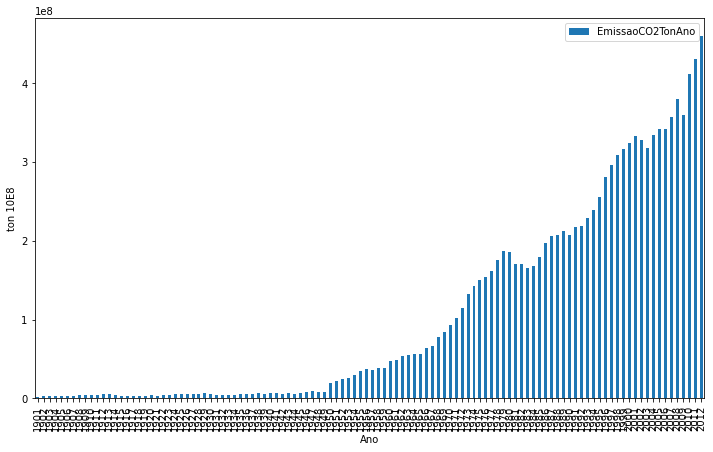

In [ ]:
dfbr.plot.bar(x='Ano', y='EmissaoCO2TonAno', figsize=(12,7),  xlabel='Ano',ylabel='ton 10E8')


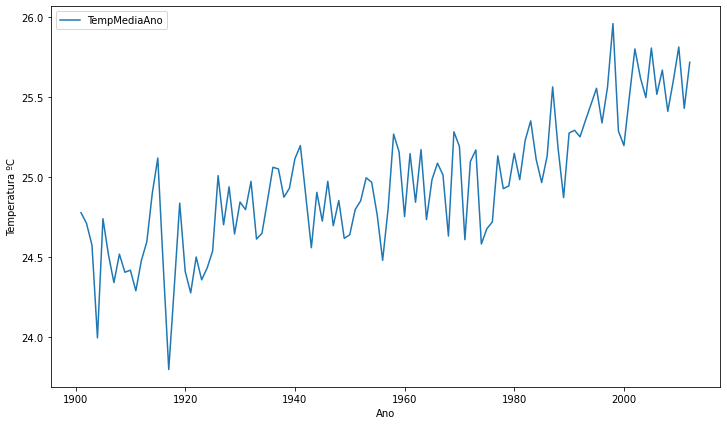

In [ ]:
dfbr.plot.line(x='Ano', y='TempMediaAno', figsize=(12,7),  xlabel='Ano',ylabel='Temperatura ºC')

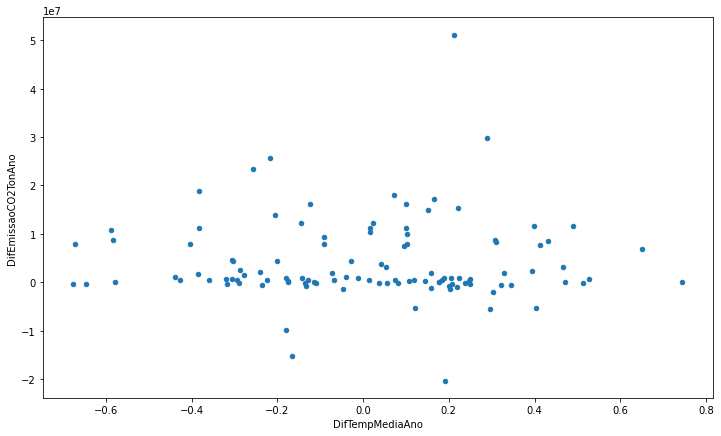

In [ ]:
dfbr.plot.scatter(x='DifTempMediaAno', y='DifEmissaoCO2TonAno', figsize=(12,7))

In [ ]:
greenland=df_plot['Pais']=='Greenland'
dfgl=df_plot.loc[greenland]
dfgl

,Pais,Codigo,Continente,Regiao,NivelDesenvolvimento,Ano,TempMediaAno,DifTempMediaAno,EmissaoCO2TonAno,DifEmissaoCO2TonAno
5183,Greenland,GRL,América,América do Norte,Desenvolvido,1950,-18.126750,1.033083,98928.0,NaN
5184,Greenland,GRL,América,América do Norte,Desenvolvido,1951,-18.963917,-0.837167,98928.0,0.0
5185,Greenland,GRL,América,América do Norte,Desenvolvido,1952,-17.874750,1.089167,106256.0,7328.0
5186,Greenland,GRL,América,América do Norte,Desenvolvido,1953,-18.384750,-0.510000,120912.0,14656.0
5187,Greenland,GRL,América,América do Norte,Desenvolvido,1954,-17.915917,0.468834,102592.0,-18320.0
...,...,...,...,...,...,...,...,...,...,...
5241,Greenland,GRL,América,América do Norte,Desenvolvido,2008,-17.389917,-0.315750,659520.0,21984.0
5242,Greenland,GRL,América,América do Norte,Desenvolvido,2009,-17.316417,0.073500,575248.0,-84272.0
5243,Greenland,GRL,América,América do Norte,Desenvolvido,2010,-15.546333,1.770083,663184.0,87936.0
5244,Greenland,GRL,América,América do Norte,Desenvolvido,2011,-17.174333,-1.628000,707152.0,43968.0


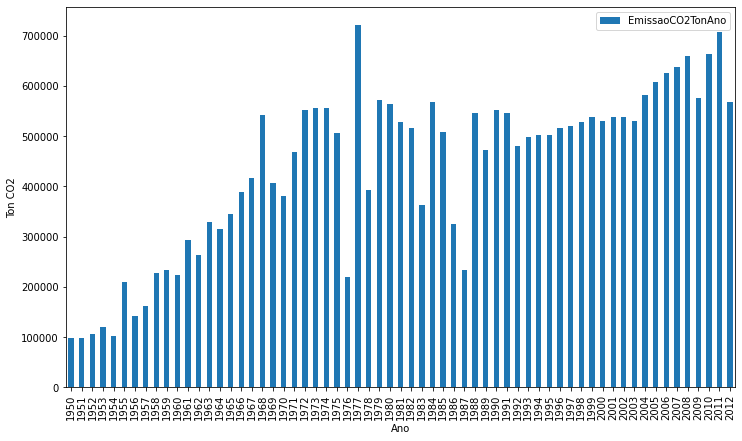

In [ ]:
dfgl.plot.bar(x='Ano', y='EmissaoCO2TonAno', figsize=(12,7), ylabel= 'Ton CO2')

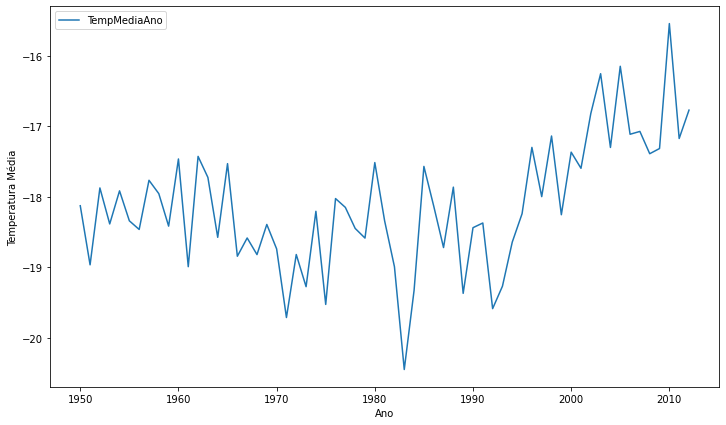

In [ ]:
dfgl.plot.line(x='Ano', y='TempMediaAno', figsize=(12,7), ylabel= 'Temperatura Média')

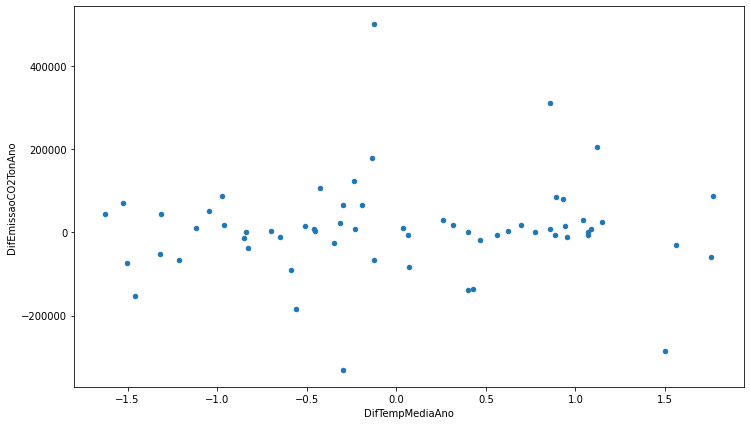

In [ ]:
dfgl.plot.scatter(x='DifTempMediaAno', y='DifEmissaoCO2TonAno', figsize=(12,7))

Definição de função, para poder salvar o arquivo pyspark diretamente para o Bucket/Data Lake, utilizando como intermédio o ambiente do drive

In [ ]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

Arquivo salvo no Bucket/Data Lake:

In [ ]:
upload_blob("projeto-final-bucket-g5", "/content/drive/MyDrive/df_temp_co2_final.csv/DF_temp_co2_final.csv", "saida/df_temp_co2_final.csv")


File /content/drive/MyDrive/df_temp_co2_final.csv/DF_temp_co2_final.csv uploaded to saida/df_temp_co2_final.csv.
